# Sending a pulse through a 3 cavity-2 qubit system, <mark>without thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Generating a pulse wave**
    * No thermal losses considered
5. **Results**
    * Final state, Fidelity, Concurrence

*Author* : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
*Supervisor* : Yu-Chin Chao (ychao@fnal.gov) <br>
*Date*$\ \ \ \$: 8th July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

The code calculates the occupation probabilities of the components in the system. It also calculates the Fidelity and Concurrence of the system.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [66]:
"""------------- FREQUENCIES --------------------"""
w_q1 = 2*pi*6.5;    # Qubit 1 frequency
w_q2 = 2*pi*6.8;    # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1      # Resonator/ Filter frequency

# from notebook on 3 cavities we saw that cavity splits into 3 levels
w_f1 = 2*pi*6.933
w_f2 = 2*pi*7.1
w_f3 = 2*pi*7.2668

"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.0118    # Filter-filter coupling
g_f2 = 2*pi*0.0344 
g_q1f = 2*pi*0.0135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.0415   # qubit 2-fitler coupling

numF = 3            # number of filters
N = 2               # number of fock states 

times = np.linspace(0,200,1000)
width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 5
T_gate_1 = (1*pi)/(2 * g_q1f) # take qubit 1 from 1->0

# resonant iSWAP gate
T0_2 = 75
T_gate_2 = (1*pi)/(g_q1f) # take qubit 2 from 0 -> 0.5

# amplitude to raise pulse above cavity frequency (optional)
d = 0.0
w_d = w_f2 + 2*pi*d

## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [55]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m1*m2.dag()

### 3.1 Operators 

In [45]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

# collapse operators
c_ops = []

### 3.2 Hamiltonian's and initial state

In [46]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = 0.5*sz1       
Hq2 = 0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# time-independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf
 
H = H0 + w_q1*Hq1 + w_q2*Hq2  # Resultant Hamiltonian

### 3.3 Initial State

In [47]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

## 4. Generating the pulse wave

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 + \sum_{i=0}^n c_i(t)H_i$$
where $H_0$ is called the time-independent drift Hamiltonian and $H_i$ are the control Hamiltonians with a time varying amplitude $c_i(t)$.

The Hamiltonian is written in a function-based time dependent way (see other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html)). Here the time-dependent coefficients, $f_n(t)$, of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Function generators

In [56]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)
 
def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f

def wf1_t(t, args=None):
    return w_f1

def wf2_t(t, args=None):
    return w_f2

def wf3_t(t, args=None):
    return w_f3
  
def w1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return w_q1 + step_t(0.0, w_d-w_q1, T0_1, width, t) - step_t(0.0, w_d-w_q1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 2
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q2) at T0_2 
    """
    return w_q2 + step_t(0.0, w_d-w_q2, T0_2, width, t) - step_t(0.0, w_d-w_q2, T0_2+T_gate_2, width, t)

def plotFrequencies(ax, times, wf_t, Colour, labels_, linestyle_):
    """
    Function plots the frequencies as a function of times
    """
    ax.plot(times, np.array(list(map(wf_t, times)))/(2*pi), Colour, linewidth=2, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 
    
def setLabels(ax, tr, th, plot_no):
    """
    Function sets the labels of the x-y axis in the plot below
    """
    if plot_no == 0:
        ax.set_ylabel("Frequency (GHz)", fontsize=16)
        ax.set_title(labelTimes(tr, th))
    else:
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Occupation \n probability")
    return 

def plotProb(ax, times, component, res, Colour, labels_, linestyle_):
    """
    Function plots the occupation probabilities of the components after running mesolve
    """
    ax.plot(times, np.real(expect(component, res.states)), Colour, linewidth=1.5, label=labels_, linestyle=linestyle_)
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return

In [67]:
opts = Odeoptions(max_step=0.005, nsteps=10000)

# time dependent Hamiltonian
H_t = [H0 , [Hq1, w1_t], [Hq2, w2_t]]

# Evolving the system
res = mesolve(H_t, psi0, times, c_ops, [])

### 4.2 Plotting the results (No thermal losses)

Note: Resonating $q_1$ and $q_2$ with the $1^{\rm st}$ and $3^{\rm rd}$ mode of the filter does not result in the effect produced by the iSWAP gate. 

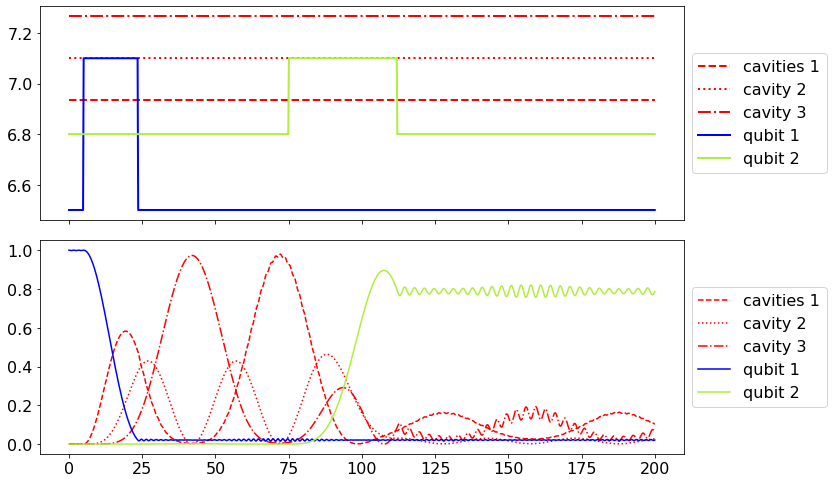

In [69]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,7))

labels_ = ["cavities 1", "cavity 2", "cavity 3", "qubit 1", "qubit 2"]
w_list = [wf1_t, wf2_t, wf3_t, w1_t, w2_t]
colors_ = ['r', 'r', 'r', 'b', '#b0ed3e']
linestyle_ = ['--', ':', '-.', '-', '-']
components_ = [numOp(a1), numOp(a2), numOp(a3), n1, n2]

for i in [0, 1, 2, 3, 4]:
    plotFrequencies(axes[0], times, w_list[i], colors_[i], labels_[i], linestyle_[i])
#setLabels(axes[0], tr, th, 0)

for i in [0, 1, 2, 3, 4]:
    plotProb(axes[1], times, components_[i], res, colors_[i], labels_[i], linestyle_[i])
#setLabels(axes[1], tr, th, 1)

fig.tight_layout()

## 5. Results

In [39]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [3,4])
rho_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.02097221+0.j         -0.12262836-0.03827793j
   0.        +0.j        ]
 [ 0.        +0.j         -0.12262836+0.03827793j  0.78689449+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.19213331+0.j        ]]

In [40]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,0), basis(2,1)))
rho_qubits_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

### 5.2 Fidelity and Concurrence

In [41]:
fidelity(rho_qubits, rho_qubits_ideal)

0.7256457148130746

In [42]:
concurrence(rho_qubits)

0.25692733178663407